In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from mousestyles import data
from mousestyles import path_diversity
from mousestyles.visualization import path_diversity_plotting
from mousestyles.data.utils import pull_locom_tseries_subset, total_time_rectangle_bins

In [2]:
# strain, mouse, day
movement = data.load_movement(0, 0, 0)

In [3]:
# Probably need one function in dataloader?
start_time, stop_time = data.load_start_time_end_time(0, 0, 0)

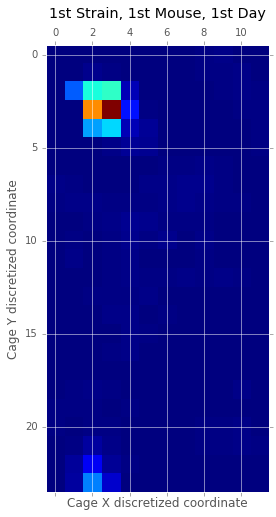

In [4]:
# Replicate the plot from begin script
YLower = 1.0; YUpper = 43.0; XUpper = 3.75; XLower = -16.25
xbins = 12; ybins = 24
M = np.vstack([movement['t'].ravel(), movement['x'].ravel(), movement['y'].ravel()])
pos_subset = pull_locom_tseries_subset(M, start_time, stop_time)
bin_times = total_time_rectangle_bins(pos_subset, xlims=(XLower, XUpper), ylims=(YLower, YUpper), xbins=xbins, ybins=ybins)
position_pdf = bin_times / bin_times.sum()

# Plot
plt.figure(figsize=(1, 2))
plt.matshow(position_pdf)
plt.title('1st Strain, 1st Mouse, 1st Day')
plt.xlabel('Cage X discretized coordinate')
plt.ylabel('Cage Y discretized coordinate')
plt.savefig("heatmap.png", dpi=(100))
plt.show()

### Exploratory Date Analysis

In [5]:
# strain, mouse, day
movement = data.load_movement(0, 0, 0)

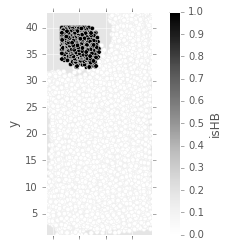

In [6]:
# Scatter plot of the location
movement.plot.scatter(x='x', y='y', c='isHB')
plt.axes().set_aspect('equal')
plt.xlim(XLower, XUpper)
plt.ylim(YLower, YUpper)
plt.show()

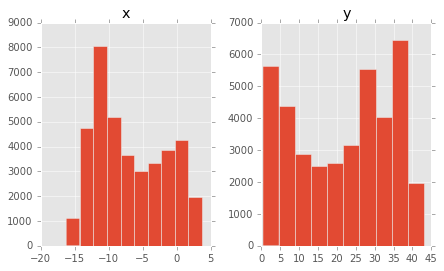

In [7]:
# Histogram of x and y
movement[['x', 'y']].hist(bins=10, figsize=(7, 4))
plt.show()

### Distance & Speed

In [8]:
# Parameters
strain = [0, 1, 2]
mouse = [0, 1, 2, 3]
# Some only have 9 days
day = [0, 1, 2 ,3, 4, 5, 6, 7, 8, 9, 10, 11]

In [9]:
def explore_mouse(stop_threshold, min_path_length, time_threshold, attribute):
    start_time = time.time()
    all_mouse = {s: {m: [] for m in mouse} for s in strain}
    
    for s in strain:
        for m in mouse:
            for d in day:
                try: 
                    movement = data.load_movement(s, m, d)
                    # Clean the duplicated rows in movement
                    movement = path_diversity.clean_movements([movement])[0]
                    
                    # Create the path
                    paths = path_diversity.path_index(movement, stop_threshold, min_path_length)
                    
                    # If time_threshold provided, filter the path based on that
                    if time_threshold:
                        paths = path_diversity.filter_path(movement, paths, time_threshold)
                    
                    values = []
                    # Start calculate attributes
                    for path in paths:
                        if (attribute == "distance") or (attribute == "speed"):
                            if attribute == "distance":
                                values.append(sum(path_diversity.get_dist_speed(movement,
                                                                                path[0],
                                                                                path[1])[0]))
                            else:
                                values.append(np.mean(path_diversity.get_dist_speed(movement,
                                                                                    path[0],
                                                                                    path[1])[1]))
                        elif attribute == "acceleration":
                            time_p = movement['t'].ravel()[path[0]:(path[1] + 1)]
                            speed = path_diversity.get_dist_speed(movement, path[0], path[1])[1]
                            values.extend(path_diversity.compute_accelerations(speed, time_p.tolist()))
                        elif attribute == "angle":
                            angles = path_diversity.compute_angles(movement.iloc[path[0]:(path[1] + 1)])
                            angles = [a for a in angles if a is not None]
                            values.extend(angles)
                        
                    all_mouse.get(s).get(m).append(values)    
                except: next
    
    print("--- %s seconds ---" % (time.time() - start_time))
    return(all_mouse)

In [10]:
mouse_distance = explore_mouse(1, 1, 15, "distance")

--- 171.30948686599731 seconds ---


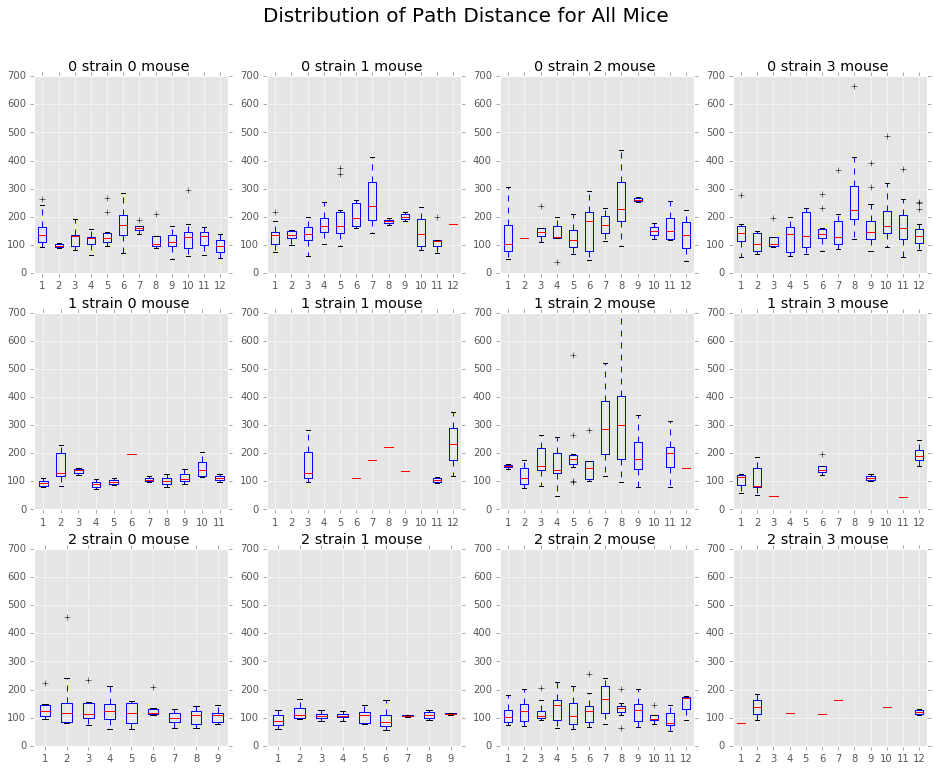

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for s in strain:
    for m in mouse:
        axes[s][m].boxplot(mouse_distance[s][m])
        axes[s][m].set_title(str(s) + ' strain ' + str(m) + ' mouse ')
        axes[s][m].set_ylim([0, 700])

plt.suptitle("Distribution of Path Distance for All Mice", fontsize=20)
plt.savefig("mouse_distance_15.png", dpi=(200))
plt.show()

In [12]:
mouse_speed = explore_mouse(1, 1, 15, "speed")

--- 178.13832902908325 seconds ---


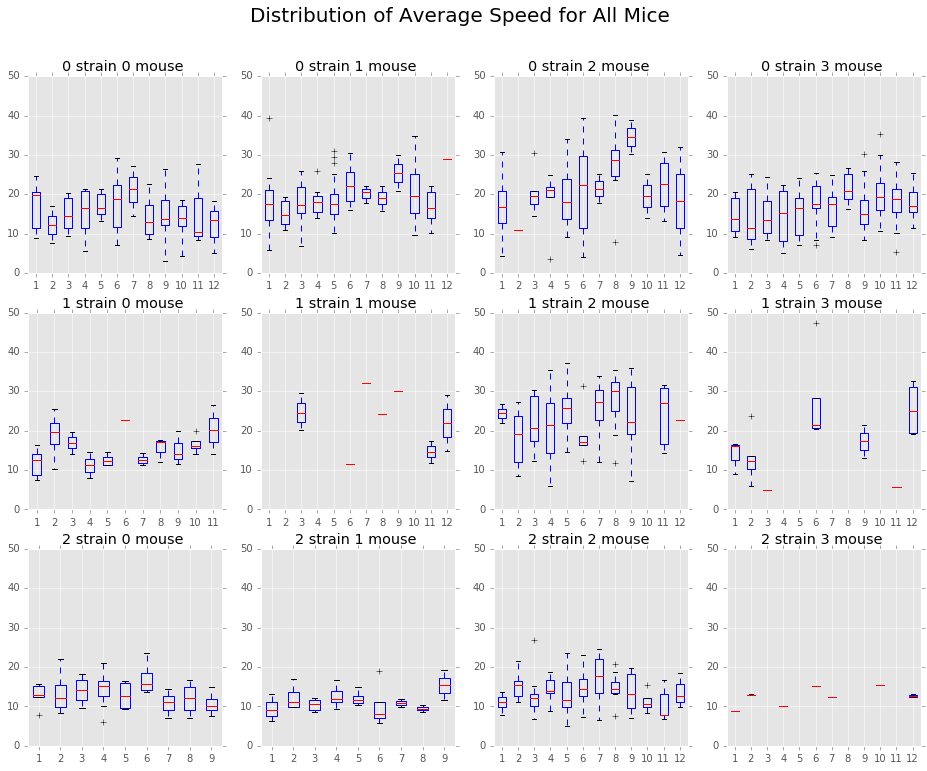

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for s in strain:
    for m in mouse:
        axes[s][m].boxplot(mouse_speed[s][m])
        axes[s][m].set_title(str(s) + ' strain ' + str(m) + ' mouse ')
        axes[s][m].set_ylim([0, 50])

plt.suptitle("Distribution of Average Speed for All Mice", fontsize=20)
plt.savefig("mouse_speed_15.png", dpi=(200))
plt.show()

In [14]:
mouse_acceleration = explore_mouse(1, 1, 15, "acceleration")

--- 180.19376730918884 seconds ---


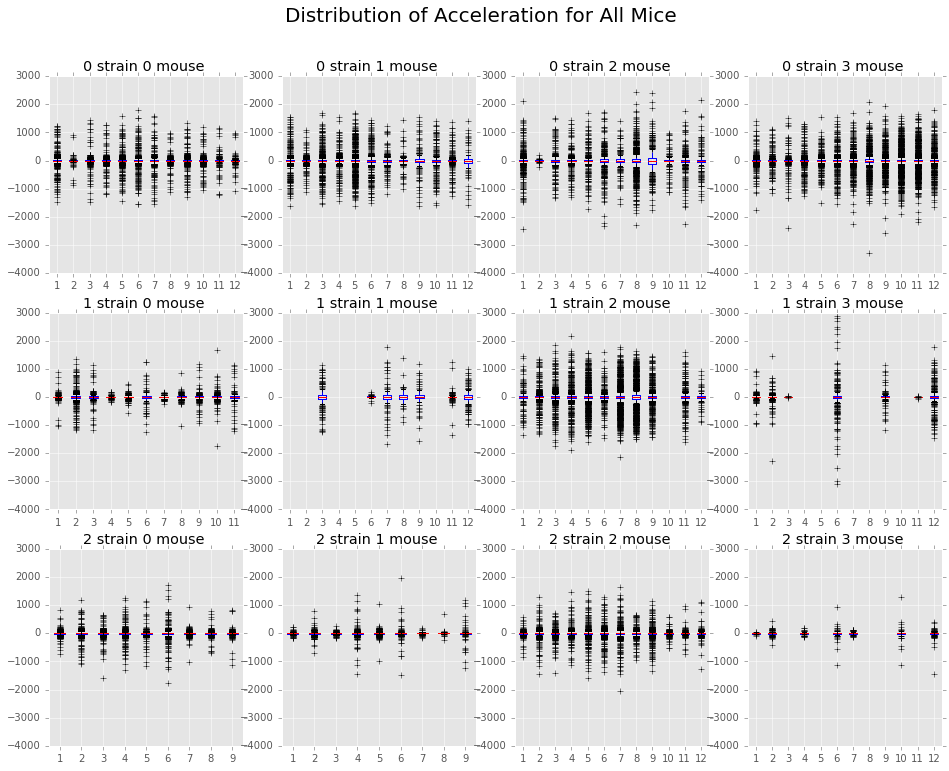

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for s in strain:
    for m in mouse:
        axes[s][m].boxplot(mouse_acceleration[s][m])
        axes[s][m].set_title(str(s) + ' strain ' + str(m) + ' mouse ')
        axes[s][m].set_ylim([-4000, 3000])

plt.suptitle("Distribution of Acceleration for All Mice", fontsize=20)
plt.savefig("mouse_acceleration_15.png", dpi=(200))
plt.show()

In [16]:
mouse_angle = explore_mouse(1, 1, 15, "angle")

--- 250.1203739643097 seconds ---


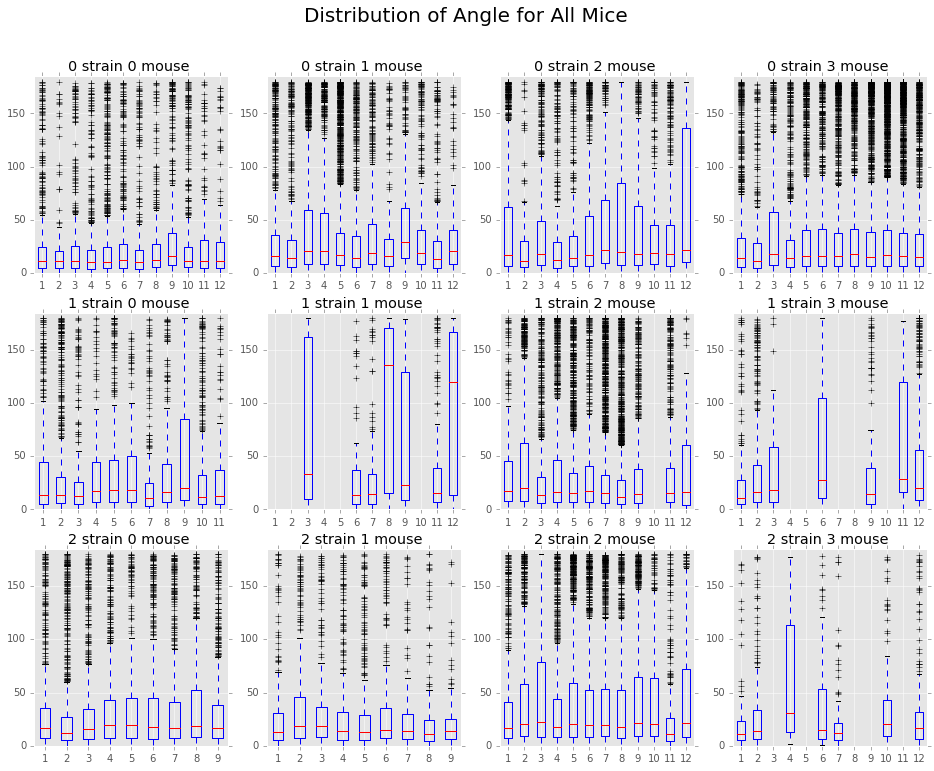

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

for s in strain:
    for m in mouse:
        axes[s][m].boxplot(mouse_angle[s][m])
        axes[s][m].set_title(str(s) + ' strain ' + str(m) + ' mouse ')
        axes[s][m].set_ylim([0, 185])

plt.suptitle("Distribution of Angle for All Mice", fontsize=20)
plt.savefig("mouse_angle_15.png", dpi=(200))
plt.show()

### Problems?

In [18]:
# First two observation are different times but with the same coordinates
movement.head()

,t,x,y,isHB
0,49529.76,-10.760,36.113,True
1,49530.89,-10.760,36.113,True
2,49696.73,-11.046,37.078,True
3,49698.51,-11.548,36.189,True
4,49706.59,-10.979,37.033,True
